In [1]:
from pca_items.intrinsic_dimension import IntrinsicDimensionRMT as ID
from pca_items.noise_estimation import MultipleRegressionClassicNoiseEstimator as NE

In [2]:
from visuals import *

In [3]:
import os
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt 
import sys

In [4]:
# Testing materials:
target_f = "box_rfl_phase"
main_path = "/beegfs/scratch/makiper/Mosaics/flight_products/"
target_paths = [os.path.join(main_path, date, "box_mosaics", target_f) for date in DATES]

target_date = DATES[0]
target_path = os.path.join(main_path, target_date, "box_mosaics", target_f)
raster = gdal.Open(target_path)
print(f"X: {raster.RasterXSize}, Y: {raster.RasterYSize}, Z: {raster.RasterCount}")

# just grabbing the center of the plot to make it easy
x_start, y_start = int(raster.RasterXSize/2)+100, int(raster.RasterYSize/2)+100
x_length, y_length = 11,11

X: 13739, Y: 12023, Z: 425


In [5]:
reflectances = reflectance_time_series_from_files(DATES, target_paths, x_start, y_start, x_length, y_length, remove_water_bands=True)
get_shape(reflectances)

[=============] 100%  Dataset Completed: 13

(11, 11, 425)

In [6]:
wl = np.array(list(WAVELENGTHS))
# reflectances['20220224'][:,:,np.logical_and(wl > 1340, wl < 1460)] = np.nan

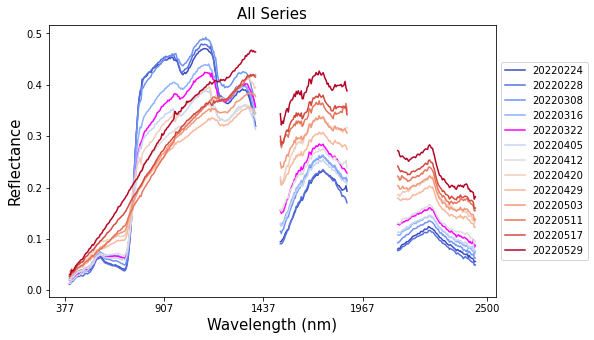

In [7]:
plot_reflectances_via_pixel(reflectances, series=True, highlight="20220322")
# plot_reflectances_via_pixel(reflectances)

In [8]:
def remove_nans(ds:np.array):
    total = []
    for x in range(ds.shape[0]):
        row = []
        for y in range(ds.shape[1]):
            row.append([x for x in ds[x][y] if str(x) != 'nan'])
        total.append(row)
    return np.array(total)

def flatten(mat:np.array):
    return np.reshape(mat, (mat.shape[0]*mat.shape[1], mat.shape[2]))

In [9]:
r = remove_nans(reflectances['20220224'])
f = flatten(r)

In [10]:
noise_est = NE()
intrinsic_dim = ID()

In [11]:
# now get the noise covarience matrix and the intrinsic dimensionality of the flattened matrix
noise = noise_est(f)
_id = intrinsic_dim(f, noise)

/home/makiper/Notebooks/pca_items/intrinsic_dimension.py:90: ComplexWarning: Casting complex values to real discards the imaginary part
  rhos[b] = np.dot(evecs1[:, b], np.dot(phi, evecs2[:, b]))/np.dot(evecs1[:, b], evecs2[:, b])


In [12]:
def reconstruct(ds, eigen_vecs, n):
    return (ds@eigen_vecs[:,:n])@eigen_vecs[:,:n].T

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


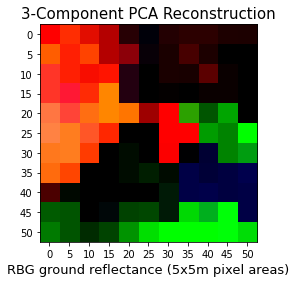

In [13]:
# plots for the PCA

def pca_heatmap(ds, eigen_vecs):
    ds_means = np.nanmean(ds, axis=0, keepdims=True)
    r = (ds-ds_means)
    projection = (r@eigen_vecs.real[:,:3])
    
    r, g, b = np.reshape(projection[:,0], (11,11)), np.reshape(projection[:,1], (11,11)), np.reshape(projection[:,2], (11,11))
    
    img = np.reshape(projection, (11, 11, 3))
    plt.xticks(range(img.shape[0]), np.array(range(img.shape[0]))*5) # multily the labels by 5 as each pixel is 5x5 meters
    plt.yticks(range(img.shape[1]), np.array(range(img.shape[1]))*5) # multily the labels by 5 as each pixel is 5x5 meters
    plt.title(str(3)+"-Component PCA Reconstruction", fontsize=15)
    plt.xlabel("RBG ground reflectance (5x5m pixel areas)", fontsize=13)
    plt.imshow(img);
    
pca_heatmap(f, _id['eigen_vectors'])

In [14]:
# reflectance_pcas
noise_est = NE()
intrinsic_dim = ID()

reflectance_pca = {}
for date, ds in reflectances.items():
    r = remove_nans(ds)
    f = flatten(r)
    noise = noise_est(f)
    _id = intrinsic_dim(f, noise)
    reflectance_pca[date] = {'ds':f, 'id': _id}

In [15]:
class spatial_pca_plots():
    def __init__(self, reflectance_pcas):
        # {'ds', 'id':{'intrinsic_dimension', 'eigen_vectors', 'eigen_vales'} }
        self.reflectance_pcas = reflectance_pcas
    
    def spatial_pca_plot(self, Date):
        ds = self.reflectance_pcas[Date]['ds']
        eigen_vecs = self.reflectance_pcas[Date]['id']['eigen_vectors']
        
        ds_means = np.nanmean(ds, axis=0, keepdims=True)
        r = (ds-ds_means)
        projection = (r@eigen_vecs.real)[:,:3]

        r, g, b = np.reshape(projection[:,0], (11,11)), np.reshape(projection[:,1], (11,11)), np.reshape(projection[:,2], (11,11))

        img = np.reshape(projection, (11, 11, 3))
        plt.xticks(range(img.shape[0]), np.array(range(img.shape[0]))*5) # multily the labels by 5 as each pixel is 5x5 meters
        plt.yticks(range(img.shape[1]), np.array(range(img.shape[1]))*5) # multily the labels by 5 as each pixel is 5x5 meters
        plt.title(str(3)+"-Component PCA Reconstruction", fontsize=15)
        plt.xlabel("RBG ground reflectance (5x5m pixel areas)", fontsize=13)
        plt.imshow(img);

def dynamic_pca_space(reflectance_pcas) -> None:
    """
    """
    p = spatial_pca_plots(reflectance_pcas)
        
    print("\n") #just for visual spacing
    dates = list(reflectance_pcas.keys())
    widgets.interact(p.spatial_pca_plot, Date=dates);
    print("\n") #just for visual spacing

In [16]:
dynamic_pca_space(reflectance_pca)

interactive(children=(Dropdown(description='Date', options=('20220224', '20220228', '20220308', '20220316', '2…

In [17]:
class _pca_plots():
    def __init__(self, ds, eigen_vecs):
        self.ds = ds
        self.eigen_vecs = eigen_vecs
    
    def _pca_plot(self, Num_Components:int):
        fig = plt.figure(figsize=(15,7))
        min_w, max_w = min(WAVELENGTHS), max(WAVELENGTHS)
        div = 20
        ticks = [int(i) for i in np.linspace(min_w, max_w, div)]
        replacement_ticks = [int(i) for i in np.linspace(0,len(WAVELENGTHS),div)]
        plt.xticks(replacement_ticks, ticks)
        plt.grid('on')
        plt.xlabel("Wavelength (nm)", fontsize=15)
        plt.ylabel("Reflectance", fontsize=15)
        n = Num_Components
        r = reconstruct(self.ds, self.eigen_vecs, n).real
        r = r[0]
        plt.plot(r);
    
def show_dynamic_visual_plot(ds, eigen_vecs, max_n:int) -> None:
    """
    """
    p = _pca_plots(ds, eigen_vecs)
        
    print("\n") #just for visual spacing
    widgets.interact(p._pca_plot, Num_Components=(1,max_n,1));
    print("\n") #just for visual spacing

In [18]:
# NOTE: How to account for this being the reconstruction from not having the water bands? 
show_dynamic_visual_plot(f, _id['eigen_vectors'], _id['intrinsic_dimension'])

interactive(children=(IntSlider(value=74, description='Num_Components', max=148, min=1), Output()), _dom_class…

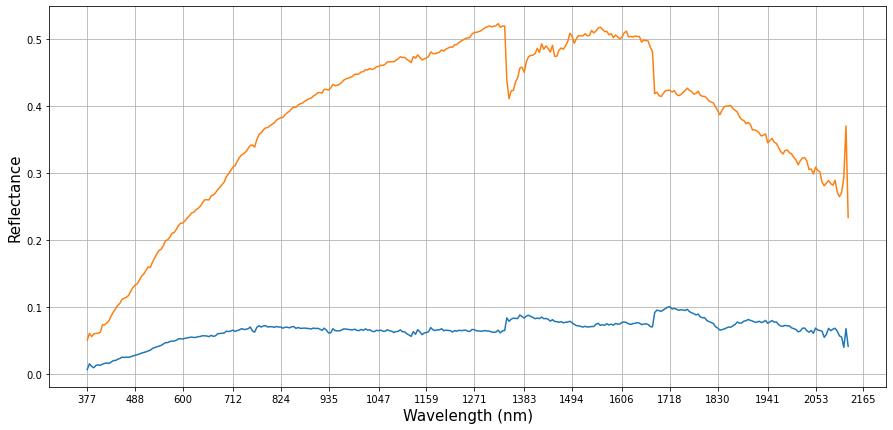

In [19]:
f_means = np.nanmean(f, axis=0, keepdims=True)

fig = plt.figure(figsize=(15,7))
min_w, max_w = min(WAVELENGTHS), max(WAVELENGTHS)
div = 20
ticks = [int(i) for i in np.linspace(min_w, max_w, div)]
replacement_ticks = [int(i) for i in np.linspace(0,len(WAVELENGTHS),div)]
plt.xticks(replacement_ticks, ticks)
plt.grid('on')
plt.xlabel("Wavelength (nm)", fontsize=15)
plt.ylabel("Reflectance", fontsize=15)
plt.plot((f - f_means)[0]); plt.plot((f)[0]);

In [20]:
# plot with wavelengths 

# sliding window
# create corr matrix (probably very diagonal - corr with neighboring bands) - see what it looks like
# remove the bands that are most correlated with the noise - image correlation matrix - numpy corr coeffs
    # compute noise in pieces and then reconstruct
    # from Kerry's code

In [21]:
class sliding_window_pca():
    def __init__(self, reflectances:dict) -> None:
        self.reflectances = reflectances
        self.default = list(reflectances.keys())[0]
        self.noise_est = NE()
        self.intrinsic_dim = ID()
        self.PCAs = None #evantual structure: dict{'intrinsic_dimension': int, 'eigen_values': np.array, 'eigen_vectors': np.array}
        
    def pca_all(self) -> dict:
        if type(self.reflectances) is not dict:
            raise Exception("need to have 'reflectance' dictionary")
        
        self.PCAs = {}
        for key, val in self.reflectances.items():
            self.PCAs[key] = self.pca(val)
        
        return self.PCAs
        
    @staticmethod
    def pca(ds:np.array):
        # now get the noise covarience matrix and the intrinsic dimensionality of the flattened matrix
        f = flatten(ds)
        noise = noise_est(f)
        _id = intrinsic_dim(f, noise)
        return _id
        
    @staticmethod
    def flatten(mat:np.array):
        return np.reshape(mat, (mat.shape[0]*mat.shape[1], mat.shape[2]))
    
    def window_pca(self, window_size:int, date:str="", n_comp=3, fill_nan=False):
        """
        Note: assumes a 'reflectances' dictionary with shape (X_pixel_index, Y_pixel_index, Band_refelctances)
        """
        if type(self.reflectances) is not dict:
            raise Exception("need to have 'reflectance' dictionary")
            
        if  date != "" and date not in list(self.reflectances.keys()):
            raise Exception("enter valid date")
            
        max_window = min(self.reflectances[list(self.reflectances.keys())[0]].shape[:2])
        if window_size >= max_window or window_size < 1:
            raise Exception("enter valid window size")
            
        window_data = {}
        for this_date, ds in self.reflectances.items():
            if date == "" or this_date == date:
                mosaic = []
                for x in range(0, ds.shape[0], window_size):
                    x_row = []
                    for y in range(0, ds.shape[1], window_size):
                        
                        if not fill_nan:
                            if x+window_size < ds.shape[0] and y+window_size < ds.shape[1]:
                                w = ds[x:x+window_size, y:y+window_size, :]

                                pca = self.pca(w)
                                _id, eigen_val, eigen_vec = pca['intrinsic_dimension'], pca['eigen_values'], pca['eigen_vectors']

                                x_row.append(eigen_vec[:n_comp].real)
                            else:
                                # otherwise fill in with -9999
                                # TODO: change this to be a lot more memory efficient
                                x_row.append(-9999)
                        
#                         else:
#                             w = ds[x:min(x+window_size, ds.shape[0]), y:min(y+window_size, ds.shape[1]), :]
#                             # TODO: handle edge overflow
#                             # d = np.zeros((window_size,window_size, ds.shape[2]))
#                             num_nan = np.count_nonzero(np.isnan(w))
#                             if  num_nan > 0:
#                                 if num_nan == window_size**2:
#                                     x_row.append(-9999)
#                                     break
#                                 else:
#                                     mean = np.nanmean(w)
#                                     w = np.nan_to_num(w, nan=mean)
                                
#                             pca = self.pca(w)
#                             _id, eigen_val, eigen_vec = pca['intrinsic_dimension'], pca['eigen_values'], pca['eigen_vectors']

#                             x_row.append(eigen_vec[:n_comp])
                                
                    mosaic.append(x_row)
                    
                # now we have a 3D mosaic for this date:
                window_data[this_date] = mosaic
                
        # now create the from the mosaics
        for key, val in window_data.items():
            # get rid of all -9999
            print(val)
            return val




In [107]:
# plot to show the amount of explained variance temporally
import dateutil.parser as dparser
from datetime import timedelta


def temporal_pca(reflectances:dict, n_dates:int, insert_type:str="MAX_SEPARATE", non_noise=False):
    """
    • insert_type (str): 
        OPTIONS: 
        1. MAX_SEPARATE: accordng to the maximum spearability (all the interior components may change based on which ever components are maximally seperable)
        2. LEFT_HALVING: left division inserts (maximally halve the areas on both sides)
            • leaving out <- doesn't make much sense
        3. LINEAR: linearlly add each subsequent day
    """
    keys = list(reflectances.keys())
    
    if n_dates < 0:
        raise Exception("Cannot have negative 'n_dates'")
        
    if n_dates > len(keys):
        print("Maximum number of dates is "+str(len(keys))+". Converting n_dates to "+str(len(keys))+".")
        n_dates = len(keys)
        
    insert_type = insert_type.lower()
    insert_type_options = ['max_separate', 'left_halving', 'linear']
    if insert_type not in insert_type_options:
        raise Exception("'insert_type' must be one of type: ", insert_type_options)
        
    # parse dates to find the maximum and minimum dates
    # ways to insert the dates:
    # 1. accordng to the maximum spearability (all the interior components may change based on which ever components are maximally seperable) (MAX_SEPARATE)
    # • I feel like this one is the most logical ^^^
    # 2. left division inserts (maximally halve the areas on both sides)
    # 3. linearlly add each subsequent day
    
    # concatinate the lists
    master = None
    dates_used = []
    datetimes = []
    
    # now implement the insert_type
    
    if insert_type == 'linear':
        for i in range(n_dates):
            ds = remove_nans(reflectances[keys[i]])

            if master is None:
                master = ds
            else:
                master = np.concatenate([master, ds], axis=2)

            dates_used.append(keys[i])
            this_date = dparser.parse(keys[i])
            datetimes.append(this_date)
        
    if insert_type == 'max_separate':
        # find the lowest mean distances
        datetime_list = [dparser.parse(i) for i in keys]
        min_date = min(datetime_list)
        
        datetimes.append(min_date)
        
        datetime_list.pop(0)
        
        print("  Real Date  |  Desired Optimal Date  |  Difference")
        print(min_date, "|", min_date, "|", 0)
        if n_dates >= 1:
            sep = ((max(datetime_list)-min_date).days/n_dates)
            
            optimal_separated_dates = [min_date + timedelta(days=(int((sep*(i+1))))) for i in range(n_dates)]
            
            # now find the dates that are closest to these            
            for op_date in optimal_separated_dates:
                
                op_real_date_index = 0
                
                for i, d in enumerate(datetime_list):
                    old_delta = abs((op_date - datetime_list[op_real_date_index]).days)
                    new_delta = abs((op_date - d).days)
                    
                    if new_delta < old_delta:
                        op_real_date_index = i
                    
                # pop from datetime_list once used
                op_real_date = datetime_list[op_real_date_index]
                print(op_real_date, "|", op_date, "|", abs((op_real_date-op_date).days))
                
                datetimes.append(op_real_date)
                
                datetime_list.pop(op_real_date_index)
                
        # print("\nLeft Out: ", datetime_list, "\n")
        
        # now concatinate all of the dates to the master list
        match = [dparser.parse(d) in datetimes for d in keys]
        dates_used = np.array(keys)[match]
            
        for date in dates_used:
            ds = remove_nans(reflectances[date])
            if master is None:
                master = ds
            else:
                master = np.concatenate([master, ds], axis=2)
                
    print("Shape: ",master.shape)
    
    # now we have the master dataframe (x_pixel, y_pixel, bands), the keys of used dates and the datetime items of used dates
    
    # calculate the average frequency (in days) from the datetimes list
    mean_frequency = np.mean([abs((datetimes[i]-datetimes[i+1]).days) for i in range(len(datetimes)-1)])
    
    # now construct the flattened master 
    flattened_master = flatten(master)
    
    # run the pca on the falttened master dataset
    print("Running PCA...")
    if not non_noise:
        noise_est = NE()
        intrinsic_dim = ID()
        noise = noise_est(flattened_master)
        _id = intrinsic_dim(flattened_master, noise)
        
    else:
        pca = np.linalg.eig(np.cov(flattened_master, rowvar=False, bias=True))
        _id = {"eigen_values":pca[0], "eigen_vectors":pca[1], "intrinsic_dimension":len(pca[0])}
    print("Finished PCA", "\n")
    
    # now we have the PCA items
    # reutrn_dict = {"dates used": dates_used, "id":_id, "dataset":flattened_master, "mean frequancy": mean_frequency}
    reutrn_dict = {"dates used": dates_used, "id":_id, "mean frequancy": mean_frequency}
    return reutrn_dict

class explained_variance():
    def __init__(self, temporal_pca_list:list):
        self.temporal_pca = temporal_pca_list
        
    def quick_plot(self, index:int):
        if index >= len(self.temporal_pca):
            raise Exception("index out of range for temporal_pca")
        
        _id, dates, feq = self.temporal_pca[index]['id'], self.temporal_pca[index]['dates used'], self.temporal_pca[index]['mean frequancy']
        self.plot_explained_variance(_id, dates, feq)
        
    @staticmethod
    def plot_explained_variance(_id, dates=None, freq=None):
        evs = _id['eigen_values']
        num_comps = _id['intrinsic_dimension']
        explained_variance = [evs[i].real/sum(evs.real) for i in range(len(evs)) if i < num_comps]
        cum_var = [sum(evs[:i+1].real)/sum(evs.real) for i in range(len(evs)) if i < num_comps]
                
        fig = plt.figure(figsize=(15,7))
        plt.bar(range(0,len(explained_variance)), explained_variance, alpha=0.5, align='center', label='Individual conmponent explained variance')
        plt.step(range(0,len(cum_var)), cum_var, 'r', where='mid',label='Cumulative explained variance')
        plt.ylabel('Explained Variance Percent', fontsize=15)
        plt.xlabel('Principal Component Number', fontsize=15)
        plt.legend(loc='best')
        plt.grid("on")
        plt.tight_layout()

        title = "Number of IDs to explain 99% variance: "+ str(len(cum_var))
        if freq is not None:
            title += "   |   Resampling Frequency (days): "+str(freq)
        plt.title(title, fontsize=18)

        sys.stdout.write('\r')
        sys.stdout.write(f"Number of IDs: {_id['intrinsic_dimension']}")
        if dates is not None:
            print()
            sys.stdout.write('\r')
            sys.stdout.write(f"Dates: {dates}")
        sys.stdout.flush()

        plt.show()


def dynamic_explained_variance(temporal_pca_list:list) -> None:
    
    p = explained_variance(temporal_pca_list)
        
    print("\n") #just for visual spacing
    widgets.interact(p.quick_plot, index=(0,len(temporal_pca_list)-1,1));
    print("\n") #just for visual spacing

In [23]:
# now get the cumulative PCAs 
# temporal_spacings = [temporal_pca(reflectances, i) for i in range(12)]

# with open('temporal_spacings.pickle', 'wb') as file:
#     pkl.dump(temporal_spacings, file)

In [27]:
import pickle as pkl

file = open('temporal_spacings.pickle', 'rb')
temporal_spacings = pkl.load(file)

EOFError: Ran out of input

In [35]:
refl = reflectances['20220224']
r = remove_nans(refl) # takes out the NaN values from removing the water bands
f = flatten(r) # reshapes from an 11x11 area x351 bands to 121x351
print("Shape:", f.shape)

# without noise accounting:
eigen_values = np.linalg.eig(np.cov(f, rowvar=False, bias=True))[0]

# with noise accounting:
# noise = noise_est(f)
# _id = intrinsic_dim(f, noise)
# eigen_values = _id['eigen_values']

[sum(eigen_values[:i+1].real)/sum(eigen_values.real) for i in range(len(eigen_values)) if sum(eigen_values[:i+1].real)/sum(eigen_values.real) < 1]

Shape: (121, 351)


[0.8518343842453383,
 0.9909235825623023,
 0.9976337735391327,
 0.9988405195125278,
 0.9992312506544877,
 0.9994164479085558,
 0.9995289790429566,
 0.9996202988287521,
 0.9996655442004616,
 0.9996989869321437,
 0.9997308972592243,
 0.9997581192934875,
 0.9997822245332835,
 0.9998002659746356,
 0.9998167434755166,
 0.9998314801380169,
 0.9998440972620828,
 0.9998549915662596,
 0.9998654532581803,
 0.9998748126639666,
 0.9998826183957888,
 0.9998897884991407,
 0.9998963680969168,
 0.9999022611298268,
 0.9999071808425137,
 0.9999117205044474,
 0.9999157922622527,
 0.9999195111921027,
 0.9999229733875958,
 0.9999261882401063,
 0.99992919070189,
 0.9999321171594399,
 0.9999348619072373,
 0.9999374679751081,
 0.9999399180572043,
 0.9999421811620465,
 0.9999443564391701,
 0.9999465199026858,
 0.9999485860921928,
 0.9999505565522108,
 0.9999525035521608,
 0.9999543947900826,
 0.9999561837537159,
 0.9999579171404204,
 0.9999595668289697,
 0.9999611077955797,
 0.9999626096743064,
 0.999964035167

In [25]:
dynamic_explained_variance(temporal_spacings)

interactive(children=(IntSlider(value=6, description='index', max=12), Output()), _dom_classes=('widget-intera…

In [26]:
[i["id"]["intrinsic_dimension"] for i in temporal_spacings]

[162, 328, 480, 671, 866, 1000, 1191, 1354, 1519, 1723, 1957, 2087, 2265]

In [26]:
"""
What below plot(s) means:
- Shows the intrinsic dimension over the resampling rate 

- This means that the total amount of information captured is exponentially more the higher the resampling rate
    - the ID is linear with each additional resampling within the window, so as you add each resampling time, the window between each period is 
    - 1/N, and thus because of the exponential decrease in spacings coupled with the linear information gain, this plot shows to be exponentially more
    - information as you resampling rate approaches 0

"""

'\nWhat below plot(s) means:\n- Shows the intrinsic dimension over the resampling rate \n\n- This means that the total amount of information captured is exponentially more the higher the resampling rate\n    - the ID is linear with each additional resampling within the window, so as you add each resampling time, the window between each period is \n    - 1/N, and thus because of the exponential decrease in spacings coupled with the linear information gain, this plot shows to be exponentially more\n    - information as you resampling rate approaches 0\n\n'

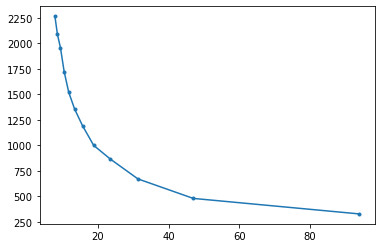

In [27]:
# realized I spelt frequency wrong lol
plt.plot([i["mean frequancy"] for i in temporal_spacings], [i["id"]["intrinsic_dimension"] for i in temporal_spacings], marker=".");

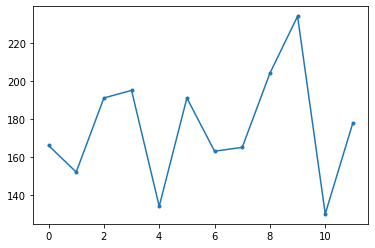

In [28]:
# plot the difference between information gain and the additional temporal period
plt.plot([temporal_spacings[i+1]["id"]["intrinsic_dimension"]-temporal_spacings[i]["id"]["intrinsic_dimension"] for i in range(len(temporal_spacings)-1)], marker=".");

In [29]:
# ignore the plot below - bad plot, doesn't provide the right analysis 

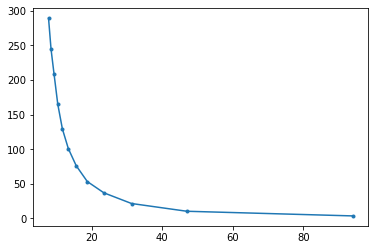

In [30]:
plt.plot([i["mean frequancy"] for i in temporal_spacings], [i["id"]["intrinsic_dimension"]/i["mean frequancy"] for i in temporal_spacings], marker=".");

In [31]:
[i["mean frequancy"] for i in temporal_spacings]

[nan,
 94.0,
 47.0,
 31.333333333333332,
 23.5,
 18.8,
 15.666666666666666,
 13.428571428571429,
 11.75,
 10.444444444444445,
 9.4,
 8.545454545454545,
 7.833333333333333]

In [32]:
"""
Shows the intrinsic dimensionality as each additional sample is added in

- Strong case for temporal independance? As the quantity of information gained by each sample addition is linear
"""

'\nShows the intrinsic dimensionality as each additional sample is added in\n\n- Strong case for temporal independance? As the quantity of information gained by each sample addition is linear\n'

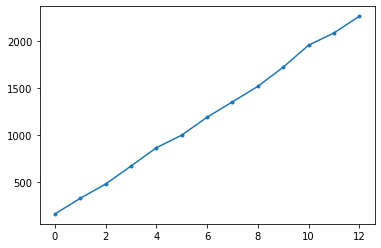

In [33]:
plt.plot([i["id"]["intrinsic_dimension"] for i in temporal_spacings], marker=".");

In [28]:
# plot the non-noise adjusted covariance eigen decomp (PCA) on the data
import dateutil.parser as dparser

# non_noise_pca = [np.linalg.eig(np.cov(flatten(remove_nans(reflectances[i])), rowvar=False, bias=True)) for i in list(reflectances.keys())]
non_noise_pca = []
for i in range(len((reflectances.keys()))):
    master = None
    
    dates_used = list(reflectances.keys())[:i+1]
    
    for date in dates_used:
        ds = remove_nans(reflectances[date])
        if master is None:
            master = ds
        else:
            master = np.concatenate([master, ds], axis=2)
            
    master = flatten(master)
    pca = np.linalg.eig(np.cov(master, rowvar=False, bias=True))
    
    datetimes = [dparser.parse(d) for d in dates_used]
    mean_frequency = np.mean([abs((datetimes[i]-datetimes[i+1]).days) for i in range(len(datetimes)-1)])
    
    this_dict = {"dates_used":dates_used, "id":{"eigen_values":pca[0], "eigen_vectors":pca[1], "intrinsic_dimension":len(pca[0])} , "mean frequancy":mean_frequency}
    non_noise_pca.append(this_dict)
    print("Finished with temporal spaceings: ", i+1)


/home/brodrick/miniconda/envs/emit/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/brodrick/miniconda/envs/emit/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Finished with temporal spaceings:  1
Finished with temporal spaceings:  2
Finished with temporal spaceings:  3
Finished with temporal spaceings:  4
Finished with temporal spaceings:  5
Finished with temporal spaceings:  6
Finished with temporal spaceings:  7
Finished with temporal spaceings:  8
Finished with temporal spaceings:  9
Finished with temporal spaceings:  10
Finished with temporal spaceings:  11
Finished with temporal spaceings:  12
Finished with temporal spaceings:  13


In [25]:
non_noise_pca_v2 = [temporal_pca(reflectances, i, non_noise=True) for i in range(len(list(reflectances.keys())))]

  Real Date  |  Desired Optimal Date  |  Difference
2022-02-24 00:00:00 | 2022-02-24 00:00:00 | 0
Shape:  (11, 11, 351)
Running PCA...


/home/brodrick/miniconda/envs/emit/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/brodrick/miniconda/envs/emit/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Finished PCA 

  Real Date  |  Desired Optimal Date  |  Difference
2022-02-24 00:00:00 | 2022-02-24 00:00:00 | 0
2022-05-29 00:00:00 | 2022-05-29 00:00:00 | 0
Shape:  (11, 11, 702)
Running PCA...
Finished PCA 

  Real Date  |  Desired Optimal Date  |  Difference
2022-02-24 00:00:00 | 2022-02-24 00:00:00 | 0
2022-04-12 00:00:00 | 2022-04-12 00:00:00 | 0
2022-05-29 00:00:00 | 2022-05-29 00:00:00 | 0
Shape:  (11, 11, 1053)
Running PCA...
Finished PCA 

  Real Date  |  Desired Optimal Date  |  Difference
2022-02-24 00:00:00 | 2022-02-24 00:00:00 | 0
2022-03-22 00:00:00 | 2022-03-27 00:00:00 | 5
2022-04-29 00:00:00 | 2022-04-27 00:00:00 | 2
2022-05-29 00:00:00 | 2022-05-29 00:00:00 | 0
Shape:  (11, 11, 1404)
Running PCA...
Finished PCA 

  Real Date  |  Desired Optimal Date  |  Difference
2022-02-24 00:00:00 | 2022-02-24 00:00:00 | 0
2022-03-16 00:00:00 | 2022-03-19 00:00:00 | 3
2022-04-12 00:00:00 | 2022-04-12 00:00:00 | 0
2022-05-03 00:00:00 | 2022-05-05 00:00:00 | 2
2022-05-29 00:00:00 |

In [31]:
dynamic_explained_variance(non_noise_pca_v2)

interactive(children=(IntSlider(value=6, description='index', max=12), Output()), _dom_classes=('widget-intera…

In [32]:
# get the number of PCA comps to explain 100% of variance
explained_var_comps = []
for items in non_noise_pca_v2:
    evs = items['id']['eigen_values']
    
    cum_sum = [sum(evs[:i+1].real)/sum(evs.real) for i in range(len(evs)) if sum(evs[:i+1].real)/sum(evs.real) < 1]
    id_ = len(cum_sum)
    explained_var_comps.append(id_)

In [33]:
[len(i['dates used']) for i in non_noise_pca_v2]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

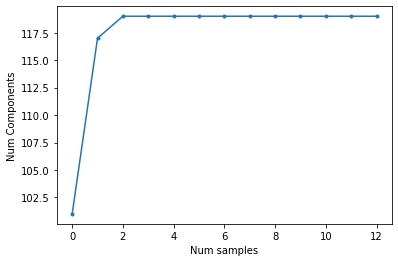

In [34]:
plt.xlabel("Num samples")
plt.ylabel("Num Components")
plt.plot(explained_var_comps, marker='.');

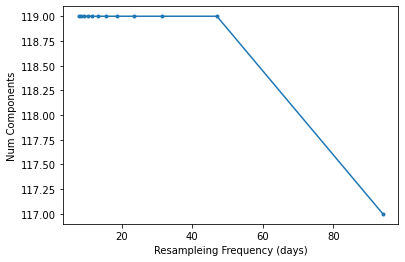

In [35]:
plt.ylabel("Num Components")
plt.xlabel("Resampleing Frequency (days)")
plt.plot([i["mean frequancy"] for i in non_noise_pca_v2[1:]], explained_var_comps[1:], marker='.');

In [36]:
# get the number of PCA comps to explain 0.9999 of variance
explained_var_comps = []
for items in non_noise_pca_v2:
    evs = items['id']['eigen_values']
    
    cum_sum = [sum(evs[:i+1].real)/sum(evs.real) for i in range(len(evs)) if sum(evs[:i+1].real)/sum(evs.real) < 0.9999]
    id_ = len(cum_sum)
    explained_var_comps.append(id_)

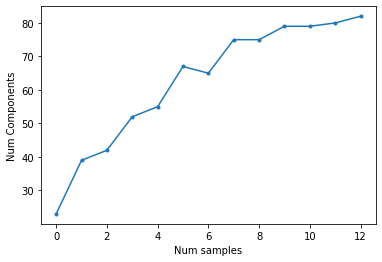

In [37]:
plt.xlabel("Num samples")
plt.ylabel("Num Components")
plt.plot(explained_var_comps, marker='.');

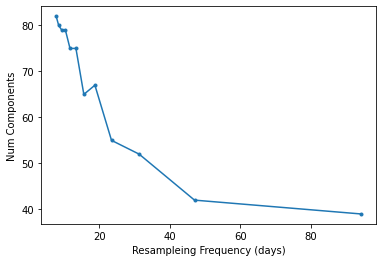

In [38]:
plt.ylabel("Num Components")
plt.xlabel("Resampleing Frequency (days)")
plt.plot([i["mean frequancy"] for i in non_noise_pca_v2[1:]], explained_var_comps[1:], marker='.');

In [13]:
pca_refl = reflectance_time_series_from_files(DATES, target_paths, x_start, y_start, x_length, y_length, remove_water_bands=False)
get_shape(pca_refl)

[=============] 100%  Dataset Completed: 13

(11, 11, 425)

In [14]:
import dateutil.parser as dparser
from datetime import timedelta

def create_raw_time_series(reflectances:dict, n_dates:int, remove_bands=True):
    keys = list(reflectances.keys())
    
    if n_dates < 0:
        raise Exception("Cannot have negative 'n_dates'")
        
    if n_dates > len(keys):
        print("Maximum number of dates is "+str(len(keys))+". Converting n_dates to "+str(len(keys))+".")
        n_dates = len(keys)
    
    # concatinate the lists
    master = None
    dates_used = []
    datetimes = []
    
    # find the lowest mean distances
    datetime_list = [dparser.parse(i) for i in keys]
    min_date = min(datetime_list)

    datetimes.append(min_date)

    datetime_list.pop(0)

    print("  Real Date  |  Desired Optimal Date  |  Difference")
    print(min_date, "|", min_date, "|", 0)
    if n_dates >= 1:
        sep = ((max(datetime_list)-min_date).days/n_dates)

        optimal_separated_dates = [min_date + timedelta(days=(int((sep*(i+1))))) for i in range(n_dates)]

        # now find the dates that are closest to these            
        for op_date in optimal_separated_dates:

            op_real_date_index = 0

            for i, d in enumerate(datetime_list):
                old_delta = abs((op_date - datetime_list[op_real_date_index]).days)
                new_delta = abs((op_date - d).days)

                if new_delta < old_delta:
                    op_real_date_index = i

            # pop from datetime_list once used
            op_real_date = datetime_list[op_real_date_index]
            print(op_real_date, "|", op_date, "|", abs((op_real_date-op_date).days))

            datetimes.append(op_real_date)

            datetime_list.pop(op_real_date_index)
                
    # print("\nLeft Out: ", datetime_list, "\n")

    # now concatinate all of the dates to the master list
    match = [dparser.parse(d) in datetimes for d in keys]
    dates_used = np.array(keys)[match]

    for date in dates_used:
        ds = reflectances[date]
        
        if remove_bands:
            ds = remove_bands_f(ds)
            
        if master is None:
            master = ds
        else:
            master = np.concatenate([master, ds], axis=2)
                
    print("Shape: ",master.shape, "\n")
    
    mean_frequency = np.mean([abs((datetimes[i]-datetimes[i+1]).days) for i in range(len(datetimes)-1)])
    
    reutrn_dict = {"dates": dates_used, "data":master, "mean_frequency": mean_frequency}
    return reutrn_dict


def remove_bands_f(ds:np.array):
    band_ranges = [(1340, 1460), (1800, 2050), 2450, 400]
    wl = np.array(WAVELENGTHS)

    cond_1 = ((wl > band_ranges[0][0]) & (wl < band_ranges[0][1]))
    cond_2 = ((wl > band_ranges[1][0]) & (wl < band_ranges[1][1]))
    cond_3 = (wl > band_ranges[2])
    cond_4 = (wl < band_ranges[3])
    indicies = np.where(cond_1 | cond_2 | cond_3 | cond_4)[0]
    
    new_ds = []
    for x in range(ds.shape[0]):
        row = []
        for y in range(ds.shape[1]):
            row.append(list(np.delete(ds[x][y], indicies)))
        new_ds.append(row)
    return np.array(new_ds)

In [15]:
raw_timeseries = [create_raw_time_series(pca_refl, i, remove_bands=True) for i in range(len(pca_refl.keys()))]

  Real Date  |  Desired Optimal Date  |  Difference
2022-02-24 00:00:00 | 2022-02-24 00:00:00 | 0
Shape:  (11, 11, 335) 

  Real Date  |  Desired Optimal Date  |  Difference
2022-02-24 00:00:00 | 2022-02-24 00:00:00 | 0
2022-05-29 00:00:00 | 2022-05-29 00:00:00 | 0
Shape:  (11, 11, 670) 

  Real Date  |  Desired Optimal Date  |  Difference
2022-02-24 00:00:00 | 2022-02-24 00:00:00 | 0
2022-04-12 00:00:00 | 2022-04-12 00:00:00 | 0
2022-05-29 00:00:00 | 2022-05-29 00:00:00 | 0
Shape:  (11, 11, 1005) 

  Real Date  |  Desired Optimal Date  |  Difference
2022-02-24 00:00:00 | 2022-02-24 00:00:00 | 0
2022-03-22 00:00:00 | 2022-03-27 00:00:00 | 5
2022-04-29 00:00:00 | 2022-04-27 00:00:00 | 2
2022-05-29 00:00:00 | 2022-05-29 00:00:00 | 0
Shape:  (11, 11, 1340) 

  Real Date  |  Desired Optimal Date  |  Difference
2022-02-24 00:00:00 | 2022-02-24 00:00:00 | 0
2022-03-16 00:00:00 | 2022-03-19 00:00:00 | 3
2022-04-12 00:00:00 | 2022-04-12 00:00:00 | 0
2022-05-03 00:00:00 | 2022-05-05 00:00:00 | 

/home/brodrick/miniconda/envs/emit/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/brodrick/miniconda/envs/emit/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Shape:  (11, 11, 2345) 

  Real Date  |  Desired Optimal Date  |  Difference
2022-02-24 00:00:00 | 2022-02-24 00:00:00 | 0
2022-03-08 00:00:00 | 2022-03-09 00:00:00 | 1
2022-03-22 00:00:00 | 2022-03-22 00:00:00 | 0
2022-04-05 00:00:00 | 2022-04-05 00:00:00 | 0
2022-04-20 00:00:00 | 2022-04-18 00:00:00 | 2
2022-05-03 00:00:00 | 2022-05-02 00:00:00 | 1
2022-05-17 00:00:00 | 2022-05-15 00:00:00 | 2
2022-05-29 00:00:00 | 2022-05-29 00:00:00 | 0
Shape:  (11, 11, 2680) 

  Real Date  |  Desired Optimal Date  |  Difference
2022-02-24 00:00:00 | 2022-02-24 00:00:00 | 0
2022-03-08 00:00:00 | 2022-03-07 00:00:00 | 1
2022-03-16 00:00:00 | 2022-03-19 00:00:00 | 3
2022-04-05 00:00:00 | 2022-03-31 00:00:00 | 5
2022-04-12 00:00:00 | 2022-04-12 00:00:00 | 0
2022-04-20 00:00:00 | 2022-04-23 00:00:00 | 3
2022-05-03 00:00:00 | 2022-05-05 00:00:00 | 2
2022-05-17 00:00:00 | 2022-05-17 00:00:00 | 0
2022-05-29 00:00:00 | 2022-05-29 00:00:00 | 0
Shape:  (11, 11, 3015) 

  Real Date  |  Desired Optimal Date  |

In [16]:
"""
TRYING OUT THE NOISE MATRIX THAT KERRY PROVIDED
"""

'\nTRYING OUT THE NOISE MATRIX THAT KERRY PROVIDED\n'

In [17]:
# import pickle
# file = open("raw_timeseries.pickle", "rb")
# raw_timeseries = pickle.load(file)

In [18]:
noise = open("SHIFT_noise_M_allbands.txt", "rb").read()
noise = str(noise).replace("b","").replace("'", "")
noise = np.array([float(i) for i in str(noise).split(",")])

In [19]:
# remove unwanted bands
print(noise.shape)
band_ranges = [(1340, 1460), (1800, 2050), 2450, 400]
wl = np.array(WAVELENGTHS)

# indicies = np.where(np.logical_and(wl <> (band_ranges[0], band_ranges[1]), wl <> (band_ranges[2], band_ranges[3]), wl < band_ranges[4], wl>band_ranges[5]))
cond_1 = ((wl > band_ranges[0][0]) & (wl < band_ranges[0][1]))
cond_2 = ((wl > band_ranges[1][0]) & (wl < band_ranges[1][1]))
cond_3 = (wl > band_ranges[2])
cond_4 = (wl < band_ranges[3])
indicies = np.where(cond_1 | cond_2 | cond_3 | cond_4)[0]
noise = np.delete(noise, indicies)
print(noise.shape)

(425,)
(335,)


In [20]:
n_est = {'noise_covariance':np.diag(noise), 'estimation_method': 'MultipleRegressionClassicNoiseEstimator'}

In [21]:
instrinsic_dimension = ID()

In [22]:
ids = []
for i, timeseries in enumerate(raw_timeseries):
    print("Series: ", len(timeseries['dates']))
    
    this_mat = flatten(timeseries['data'])
    
    this_noise = noise
    for j in range(i):
        this_noise = np.concatenate([this_noise, noise], axis=0)
        
    this_n_est = {'noise_covariance':np.diag(this_noise), 'estimation_method': 'MultipleRegressionClassicNoiseEstimator'}    
    
    instrinsic_dimension = ID()
    _id = instrinsic_dimension(this_mat, this_n_est)
    print("ID: ",_id['intrinsic_dimension'])
    ids.append(_id)

Series:  1
ID:  95
Series:  2
ID:  109
Series:  3
ID:  116
Series:  4
ID:  120
Series:  5
ID:  120
Series:  6
ID:  120
Series:  7
ID:  120
Series:  8
ID:  120
Series:  9
ID:  120
Series:  10
ID:  120
Series:  11
ID:  120
Series:  12
ID:  120
Series:  13
ID:  120


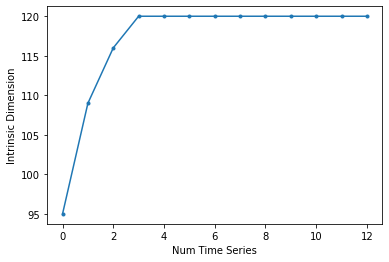

In [23]:
plt.xlabel("Num Time Series")
plt.ylabel("Intrinsic Dimension")
# plt.ylim([0, 140])
plt.plot([i["intrinsic_dimension"] for i in ids], marker=".");

In [39]:
#Overlay above pot with the non-noise CPA
non_noise_pca = []
for i, timeseries in enumerate(raw_timeseries):
    print("Series: ", i)
    f = flatten(timeseries['data'])
    evs = np.linalg.eig(np.cov(f, rowvar=False, bias=True))[0] #eigenvalues
    
    this_id = len([sum(evs[:i+1].real)/sum(evs.real) for i in range(len(evs)) if sum(evs[:i+1].real)/sum(evs.real) < 1])
    non_noise_pca.append(this_id)

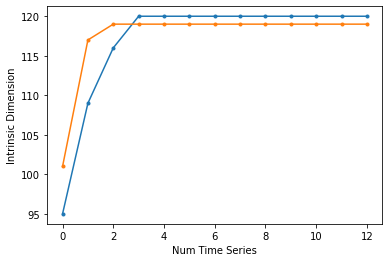

In [40]:
fig = plt.figure(figsize=(10, 7))
plt.xlabel("Num Time Series")
plt.ylabel("Intrinsic Dimension")
# plt.ylim([0, 140])
plt.plot([i["intrinsic_dimension"] for i in ids], marker=".");
plt.plot(non_noise_pca, marker=".");

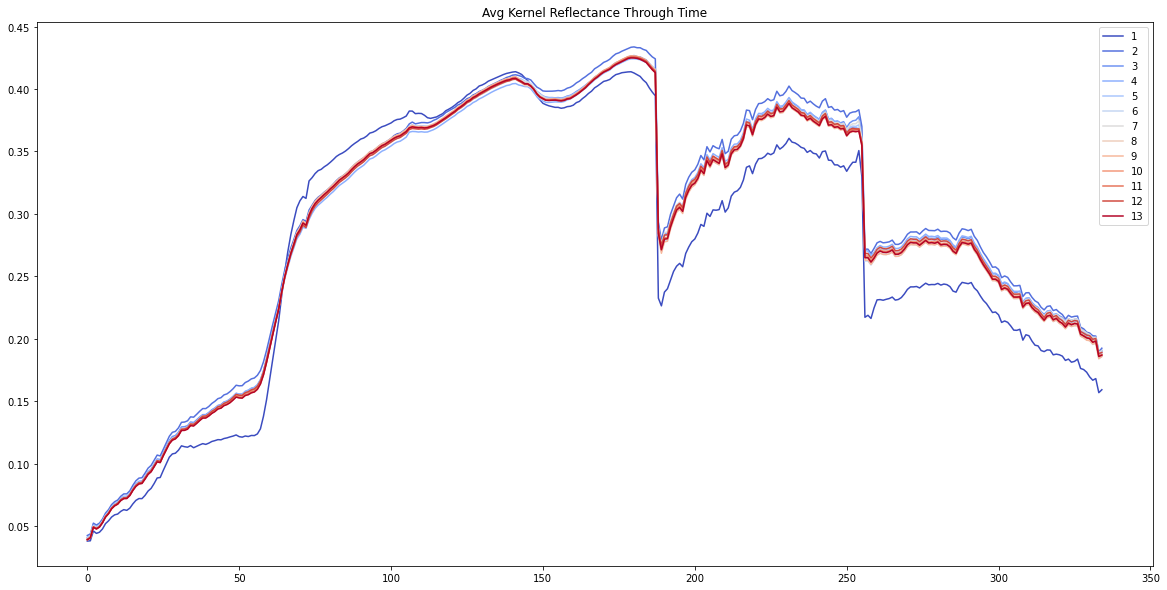

In [166]:
# TO VIEW REFLECTANCE BY YEAR, REFERENCE TOP GRAPH 
avg_rfls = []
base_dim = raw_timeseries[0]['data'].shape[-1]
for index, data in enumerate(raw_timeseries):
    data = data['data']
    f = flatten(data)
    new_f = []
    for row in f:
        r = np.reshape(row, (index+1, base_dim))
        r = np.mean(r, axis=0)
        new_f.append(r)
    # print(np.array(new_f).shape)
    this_mean_rfl = np.mean(new_f, axis=0)
    avg_rfls.append(this_mean_rfl)
    # print(np.array(this_mean_rfl).shape, "\n")
   
fig = plt.figure(figsize=(20, 10))
plt.title("Avg Kernel Reflectance Through Time")

colors = plt.cm.coolwarm(np.linspace(0,1,len(reflectances.items())))
for i, rfl in enumerate(avg_rfls):
    this_color = colors[i]
    plt.plot(avg_rfls[i], c=this_color);
plt.legend([len(raw_timeseries[i]['dates']) for i in range(len(avg_rfls))]);

In [47]:
[non_noise_pca[j] - [i["intrinsic_dimension"] for i in ids][j] for j in range(len(non_noise_pca))]

[6, 8, 3, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]

In [48]:
# does this mean that the data gets less sensitive to noise over time?

In [60]:
cum_sum = []
for series in ids:
    evs = series['eigen_values']
    indom = series['intrinsic_dimension']
    
    this_sum = [sum(evs[:i+1].real)/sum(evs.real) for i in range(indom)]
    cum_sum.append(this_sum)

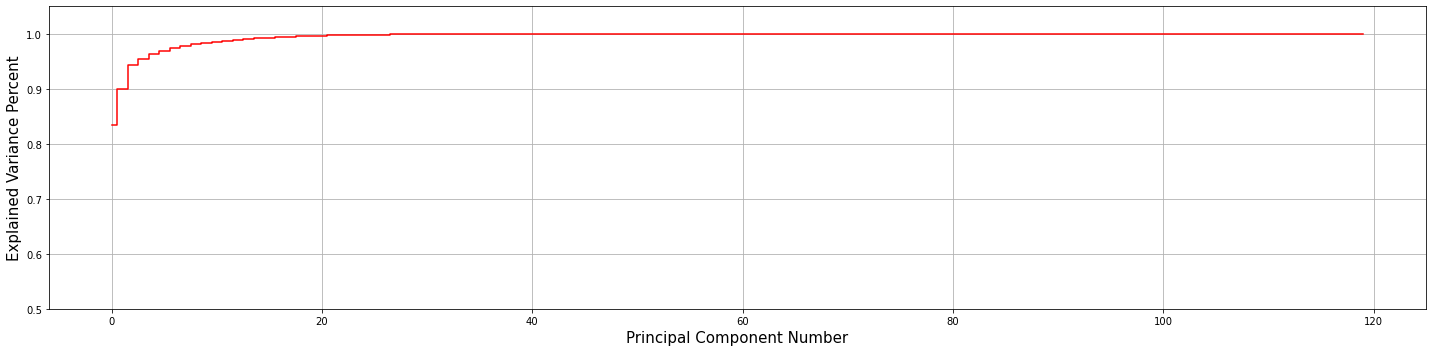

In [95]:
date = 11
cum_var = cum_sum[date]
# cum_var = [sum(cum_sum[date][:i+1])/sum()]

fig = plt.figure(figsize=(20, 5))
# plt.bar(range(0,len(explained_variance)), explained_variance, alpha=0.5, align='center', label='Individual conmponent explained variance')
plt.step(range(0,len(cum_var)), cum_var, 'r', where='mid',label='Cumulative explained variance')
plt.ylabel('Explained Variance Percent', fontsize=15)
plt.xlabel('Principal Component Number', fontsize=15)
# plt.legend(loc='right')
plt.ylim([0.5, 1.05])
plt.grid("on")
plt.tight_layout()

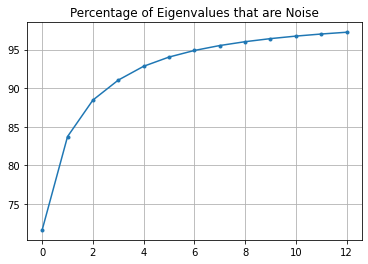

In [57]:
# amount of eigen values that are noise
plt.title("Percentage of Eigenvalues that are Noise")
plt.grid("on")
plt.plot([(len(i['eigen_values']) - i["intrinsic_dimension"])/len(i['eigen_values'])*100 for i in ids], marker='.');

In [99]:
# when you take out the noise there is more information? <- think that it's just a rounding error

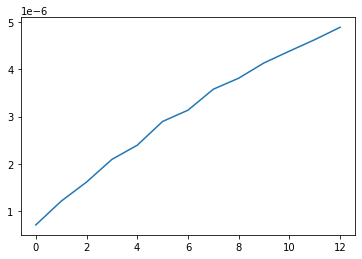

In [41]:
plt.plot([np.mean(ids[i]['rhos'][:ids[i]['intrinsic_dimension']]*ids[i]['r']) for i in range(len(ids))]);

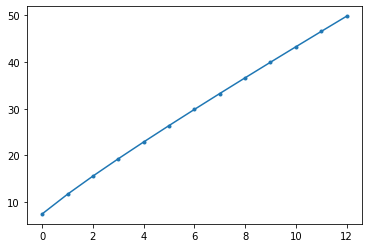

In [30]:
# [(np.mean(ids[i]['rhos']),np.mean(ids[i]['r'])) for i in range(len(ids))]

# plt.plot([np.mean(ids[i]['rhos']) for i in range(len(ids))]);
plt.plot([ids[i]['r'] for i in range(len(ids))], marker='.');

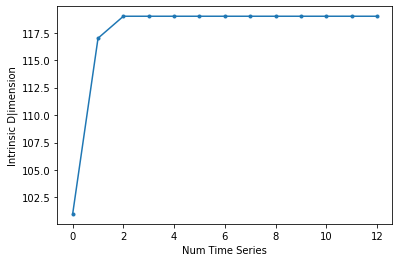

In [23]:
explained_var_comps = []
for items in ids:
    evs = items['eigen_values']
    
    cum_sum = [sum(evs[:i+1].real)/sum(evs.real) for i in range(len(evs)) if sum(evs[:i+1].real)/sum(evs.real) < 1]
    id_ = len(cum_sum)
    explained_var_comps.append(id_)

plt.xlabel("Num Time Series")
plt.ylabel("Intrinsic D|imension")
# plt.ylim([0, 100])

plt.plot(explained_var_comps, marker=".");

In [164]:
other_ids = []
for i, timeseries in enumerate(raw_timeseries):
    if i <= 7:
        print("Series: ", len(timeseries['dates']))
        print("Shape: ", timeseries['data'].shape)

        this_mat = flatten(timeseries['data'])
        
        this_n_est = NE()
        this_n_est = this_n_est(this_mat)

        instrinsic_dimension = ID()
        _id = instrinsic_dimension(this_mat, this_n_est)
        print("ID: ",_id['intrinsic_dimension'], "\n")
        other_ids.append(_id)

Series:  1
Shape:  (11, 11, 335)


/home/makiper/Notebooks/pca_items/intrinsic_dimension.py:90: ComplexWarning: Casting complex values to real discards the imaginary part
  rhos[b] = np.dot(evecs1[:, b], np.dot(phi, evecs2[:, b]))/np.dot(evecs1[:, b], evecs2[:, b])


ID:  150 

Series:  2
Shape:  (11, 11, 670)
ID:  291 

Series:  3
Shape:  (11, 11, 1005)
ID:  468 

Series:  4
Shape:  (11, 11, 1340)
ID:  653 

Series:  5
Shape:  (11, 11, 1675)
ID:  837 

Series:  6
Shape:  (11, 11, 2010)
ID:  986 

Series:  7
Shape:  (11, 11, 2345)
ID:  1191 

Series:  8
Shape:  (11, 11, 2680)
ID:  1318 



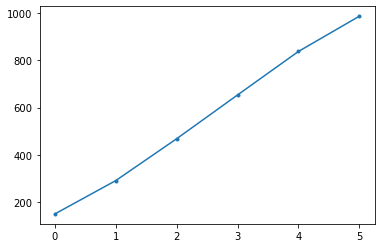

In [104]:
plt.plot([i['intrinsic_dimension'] for i in other_ids], marker=".");

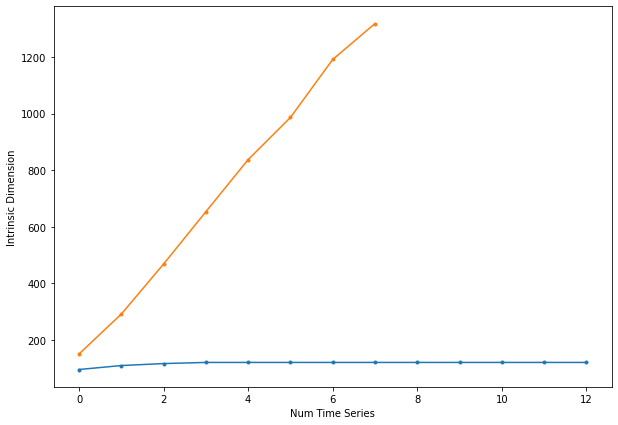

In [165]:
fig = plt.figure(figsize=(10, 7))
plt.xlabel("Num Time Series")
plt.ylabel("Intrinsic Dimension")
# plt.ylim([0, 140])
plt.plot([i["intrinsic_dimension"] for i in ids], marker=".");
plt.plot([i['intrinsic_dimension'] for i in other_ids], marker=".");
# plt.plot(non_noise_pca, marker=".");

In [114]:
# try with the Meer noise